# 2.3 实现一个大语言模型
## 2.3.1 大模型结构设计
### 目标
设计一个小模型，用于专业领域知识问答，具备基本的通用能力。
<center>
<img src='./images/pumo_LLM.png' height='600'/>

自研大模型结构图
</center>


1. **模块化设计**：
   - 每个解码器层独立实现
   - 支持分组查询注意力(GQA)
   - 包含KV缓存机制
2. **模型参数0.5B、1B、3B可配置**：
   - 0.5B模型参数计算：
   - Embedding层：100256 * 2048 ≈ 205M
   - 注意力层：24层 * (3*2048² + 2048²) ≈ 200M
   - MLP层：24层 * (3*2048*8192) ≈ 100M
3. **推理优化**：
   - 增量式KV缓存更新
   - 位置感知的cache_pos跟踪
   - 温度参数控制生成多样性
4. **训练优化**：
   - 使用RMSNorm代替LayerNorm
   - 参数初始化采用GPT风格
   - 所有线性层包含dropout



## 2.3.2 多头注意力及KV-Cache实现

- 标准multi-head attention机制
- 对KV进行缓存，提升推理性能

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math

class testAttention(nn.Module):
    def __init__(self, dim: int, n_heads: int, n_kv_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.head_dim = dim // n_heads
        
        self.wq = nn.Linear(dim, n_heads * self.head_dim)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim)
        self.wo = nn.Linear(n_heads * self.head_dim, dim)

    def forward(
        self,
        x: torch.Tensor,
        kv_cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
        cache_pos: int = 0
    ):
        bs, seq_len, _ = x.shape
        
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)

        q = q.view(bs, seq_len, self.n_heads, self.head_dim)
        k = k.view(bs, seq_len, self.n_kv_heads, self.head_dim)
        v = v.view(bs, seq_len, self.n_kv_heads, self.head_dim)

        if kv_cache is not None:
            k_cache, v_cache = kv_cache
            k = torch.cat([k_cache, k], dim=1)
            v = torch.cat([v_cache, v], dim=1)
        
        new_kv_cache = (k, v)

        k = k.repeat_interleave(self.n_heads // self.n_kv_heads, dim=2)
        v = v.repeat_interleave(self.n_heads // self.n_kv_heads, dim=2)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)    
        scores = F.softmax(scores, dim=-1)

        output = (scores @ v).transpose(1, 2).contiguous()
        output = output.view(bs, seq_len, -1)
        return self.wo(output), new_kv_cache
if __name__ == "__main__":    
    x = torch.tensor([[[ 0.0503, -0.5268, -0.4598, 1.18228],
            [ 2.2916,  0.4707,  0.7846, 0.1812],
            [ 0.1385, -0.9353, -0.0033, 0.4812],
            [ 0.3857,  2.1517, -0.2497, -0.5207]]])
    attention = testAttention(4, 2, 2)
    context = attention.forward(x)
    print(context)

(tensor([[[-0.3926, -0.1138, -0.7816,  0.5745],
         [-0.2965, -0.1407, -0.6845,  0.6323],
         [-0.3706, -0.1118, -0.7555,  0.5874],
         [-0.3238, -0.1655, -0.7054,  0.5859]]], grad_fn=<ViewBackward0>), (tensor([[[[ 0.7682,  0.1764],
          [ 0.2377,  0.1086]],

         [[ 0.7857, -1.0319],
          [-0.4040,  0.7176]],

         [[ 0.7702, -0.0665],
          [-0.0719,  0.4097]],

         [[-0.2934,  0.1201],
          [ 0.9249, -0.8144]]]], grad_fn=<ViewBackward0>), tensor([[[[-0.3901,  0.1544],
          [ 0.0181, -1.2088]],

         [[-0.0084,  0.5200],
          [ 0.6822,  0.4627]],

         [[-0.3689,  0.3770],
          [ 0.3525, -0.9972]],

         [[ 0.0135,  0.2346],
          [ 0.5637,  0.7290]]]], grad_fn=<ViewBackward0>)))


## 2.3.3 RMSNorm 实现

RMSNorm（Root Mean Square Normalization）是一种归一化技术，与传统的Layer Norm相比，RMSNorm计算更为简单高效，因为它不包含偏差项和缩放因子的调整。

### RMSNorm 实现原理

RMSNorm 的主要思想是基于输入张量的均方根（Root Mean Square, RMS）来标准化输入。对于一个输入张量 $X$，其RMSNorm定义如下：

$$ \text{RMSNorm}(X) = \frac{X}{\sqrt{\text{E}[X^2] + \epsilon}} \cdot \gamma $$

其中：
- $X$ 是输入张量，
- $\text{E}[X^2]$ 表示对输入张量的平方求平均值，
- $\epsilon$ 是为了数值稳定而添加的一个小常数，
- $\gamma$ 是可学习的缩放参数。

In [5]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-8):
        super(RMSNorm, self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x):
        # 计算输入张量平方的均值
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        # 标准化并乘以可学习的缩放参数
        x_normalized = x / rms * self.weight
        return x_normalized

# 测试RMSNorm
if __name__ == "__main__":
    batch_size, seq_len, feat_dim = 4, 3, 2
    x = torch.rand(batch_size, seq_len, feat_dim)
    rms_norm = RMSNorm(feat_dim)
    output = rms_norm(x)
    print("Input tensor:")
    print(x)
    print("\nOutput after RMSNorm:")
    print(output)

Input tensor:
tensor([[[0.7945, 0.2481],
         [0.2320, 0.3214],
         [0.5971, 0.8361]],

        [[0.0216, 0.5061],
         [0.9314, 0.9561],
         [0.7226, 0.3534]],

        [[0.6394, 0.6808],
         [0.7990, 0.0614],
         [0.1031, 0.5477]],

        [[0.6873, 0.0377],
         [0.5393, 0.9283],
         [0.5223, 0.1938]]])

Output after RMSNorm:
tensor([[[1.3499, 0.4215],
         [0.8277, 1.1467],
         [0.8219, 1.1509]],

        [[0.0604, 1.4129],
         [0.9868, 1.0130],
         [1.2705, 0.6212]],

        [[0.9681, 1.0309],
         [1.4101, 0.1083],
         [0.2617, 1.3898]],

        [[1.4121, 0.0775],
         [0.7103, 1.2229],
         [1.3259, 0.4920]]], grad_fn=<MulBackward0>)


## 2.3.4 MLP层实现

### GELU（Gaussian Error Linear Unit）激活函数

GELU是一种平滑的激活函数，它基于随机正态分布的概率计算。与ReLU、Leaky ReLU等传统激活函数相比，GELU提供了更平滑的非线性变换，有助于提高深度学习模型的表现。GELU的公式定义如下：

$$ \text{GELU}(x) = x \cdot \Phi(x) $$

其中，\(\Phi(x)\) 是高斯分布的累积分布函数(CDF)，它可以近似为：

$$ \Phi(x) \approx 0.5 \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right)\right) $$

这个近似值在实践中被广泛使用，因为它能有效减少计算成本。

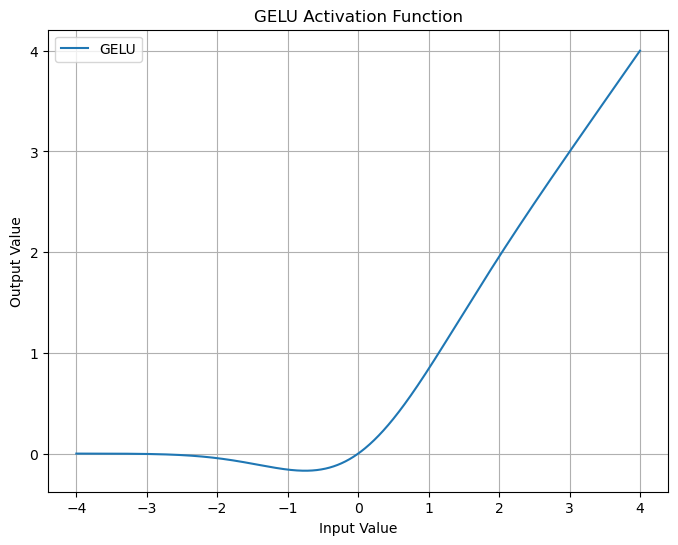

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math

def gelu(x):
    cdf = 0.5 * (1.0 + np.tanh((math.sqrt(2 / math.pi) * (x + 0.044715 * np.power(x, 3))))) 
    return x * cdf

x = np.linspace(-4, 4, 1000)
y = gelu(x)
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='GELU')
plt.title('GELU Activation Function')
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.grid(True)
plt.legend()
plt.show()

下面是MLP层的实现：

In [ ]:
class testMLP(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, dropout: float):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim).to(device)
        self.w2 = nn.Linear(hidden_dim, dim).to(device)
        self.w3 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)

    def forward(self, x: torch.Tensor):
        x = F.gelu(self.w1(x))
        gate = self.w3(x)
        return self.dropout(self.w2(x * gate))

## 2.3.5 模型类的实现
- 按照模型结构设计，组装Embedding层、Decoder层和输出层
- forward前向推理，读取KV-cache缓存

In [ ]:
class testModel(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config["vocab_size"], config["dim"]).to(device)
        self.emb_dropout = nn.Dropout(config["dropout"]).to(device)
        self.layers = nn.ModuleList([
            testDecoderLayer(
                dim=config["dim"],
                n_heads=config["n_heads"],
                n_kv_heads=config.get("n_kv_heads", config["n_heads"] // 4),
                mlp_dim=config["mlp_dim"],
                dropout=config["dropout"]
            ) for _ in range(config["n_layers"])
        ]).to(device)
        self.norm = testRMSNorm(config["dim"])
        self.lm_head = nn.Linear(config["dim"], config["vocab_size"]).to(device)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(
        self, 
        input_ids: torch.Tensor,
        kv_cache: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
        cache_pos: int = 0
    ):
        x = self.emb_dropout(self.embedding(input_ids))
        
        new_kv_cache = []
        for i, layer in enumerate(self.layers):
            layer_kv_cache = kv_cache[i] if kv_cache else None
            x, layer_kv = layer(
                x, 
                kv_cache=layer_kv_cache,
                cache_pos=cache_pos
            )
            new_kv_cache.append(layer_kv)
        
        x = self.norm(x)
        logits = self.lm_head(x)
        return logits, new_kv_cache

## 2.3.6 文本生成策略

### **贪心搜索（Greedy Search）**
**原理**：每一步都选择概率最高的token  
**优点**：计算简单、速度快  
**缺点**：容易陷入重复循环、缺乏多样性  
**适用场景**：需要快速生成结果的简单任务

In [7]:
import torch

def greedy_search(logits):
    """贪心搜索实现"""
    # logits形状: [batch_size, vocab_size]
    next_token = torch.argmax(logits, dim=-1)
    return next_token

# 使用示例
logits = torch.randn(1, 50000)  # 模拟模型输出
next_token = greedy_search(logits)
print(f"Next token: {next_token.item()}")

Next token: 9539


### **束搜索（Beam Search）**
**原理**：维护多个候选序列，保留概率最高的B个路径  
**优点**：生成质量较高  
**缺点**：内存占用大、速度慢  
**适用场景**：机器翻译、文本摘要等需要准确性的任务

In [ ]:
def beam_search(logits, k=3):
    sequences = [[list(), 0.0]]
    for score in logits:
        all_candidates = []
        for seq, prob in sequences:
            for idx, token_prob in enumerate(score):
                candidate = [seq + [idx], prob - np.log(token_prob)]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = ordered[:k]
    return sequences

# 示例logits
logits = np.array([[0.1, 0.2, 0.7], [0.5, 0.4, 0.1]])
sequences = beam_search(logits, k=2)
for seq in sequences:
    print("Sequence:", seq[0], "Score:", seq[1])

Sequence: [2, 0] Score: 1.0498221244986778
Sequence: [2, 1] Score: 1.2729656758128876



### **Top-k 采样**
**原理**：从概率最高的k个候选token中随机采样  
**优点**：平衡确定性与多样性  
**缺点**：需要调整k值  
**适用场景**：故事生成、对话系统

In [13]:
import numpy as np

def top_k_sampling(logits, k=5):
    # 对logits进行排序并获取top-k索引
    indices_to_remove = logits < np.partition(logits, -k)[-k]
    # 将不在top-k中的元素设为负无穷，以排除它们
    logits[indices_to_remove] = -float('Inf')
    # 归一化概率分布
    probs = np.exp(logits) / np.sum(np.exp(logits))
    # 根据新的概率分布随机选择一个词
    next_word = np.random.choice(len(probs), p=probs)
    return next_word

# 示例logits
logits = np.array([0.1, 0.2, 0.7, 0.5, 0.4, 0.1])
next_word = top_k_sampling(logits, k=3)
print("Next word index:", next_word)

Next word index: 4


### **Top-p（核）采样**
**原理**：按照从高到低的顺序累加词汇的概率，直到这些词汇的累积概率达到某个阈值P。然后，仅考虑这些词汇，将其他词汇的概率设为0，最后根据这个过滤后的分布进行采样。
**优点**：动态调整候选集大小  
**缺点**：需要调整p值  
**适用场景**：创意写作、诗歌生成

In [14]:
def top_p_sampling(logits, p=0.9):
    sorted_logits = -np.sort(-logits)  # 降序排列
    sorted_indices = np.argsort(-logits)
    cumulative_probs = np.cumsum(np.exp(sorted_logits - np.max(sorted_logits)))
    # 找到最后一个使得累积概率小于等于p的索引
    idx = np.searchsorted(cumulative_probs, p) + 1
    # 过滤掉不在累积概率之内的单词
    indices_to_remove = np.arange(len(logits))[~np.in1d(np.argsort(-logits), sorted_indices[:idx])]
    logits[indices_to_remove] = -float('Inf')
    # 归一化概率分布
    probs = np.exp(logits) / np.sum(np.exp(logits))
    # 根据新的概率分布随机选择一个词
    next_word = np.random.choice(len(probs), p=probs)
    return next_word

# 示例logits
logits = np.array([0.1, 0.2, 0.7, 0.5, 0.4, 0.1])
next_word = top_p_sampling(logits, p=0.75)
print("Next word index:", next_word)

Next word index: 0



### **温度采样（Temperature Sampling）**
**原理**：通过温度参数调整概率分布  
**优点**：灵活控制生成多样性  
**缺点**：需要精细调节温度值  
**适用场景**：需要控制输出随机性的场景

In [ ]:
def temperature_sampling(logits, temperature=0.7):
    """温度采样实现"""
    scaled_logits = logits / temperature
    probs = torch.softmax(scaled_logits, dim=-1)
    return torch.multinomial(probs, 1)


### **典型应用场景对比**
| 策略           | 速度 | 多样性 | 连贯性 | 适用场景               |
|----------------|------|--------|--------|-----------------------|
| 贪心搜索       | 快   | 低     | 高     | 简单问答              |
| 束搜索         | 慢   | 低     | 最高   | 机器翻译              |
| Top-k          | 中   | 中     | 中     | 通用文本生成          |
| Top-p          | 中   | 高     | 中     | 创意写作              |
| 温度采样       | 快   | 可调   | 可调   | 可控生成场景          |
| 混合策略       | 中   | 高     | 高     | 工业级文本生成        |


## 2.3.7 模型运行

模型参数为3B，可以通过配置调节参数量，由于没有经过训练，当前生成的文本还是乱码。
<center>
<img src='./images/mymodel.png' height='500'/>
</center>

